In [1]:
import numpy as np
import tensorflow as tf

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
corpus_raw = 'He is the king . The king is royal . She is the royal queen'

#convert to lower case
corpus_raw = corpus_raw.lower()

#create a list to determine the index of every word
words = []
for word in corpus_raw.split():
    if word != '.':
        words.append(word)
words = set(words)

In [3]:
word2int = {}
int2word = {}
vocab_size = len(words)
for i,word in enumerate(words):
    word2int[word] = i
    int2word[i] = word
# create dicts of index and words

In [4]:
#convert sentence to words
raw_sentences = corpus_raw.split('.')
sentences = []
for sentence in raw_sentences:
    sentences.append(sentence.split())
#every element of sentences is the words of a sentence

In [5]:
#create traing data
data = []

WINDOW_SIZE = 2

for sentence in sentences:
    for word_index,word in enumerate(sentence):
        for nb_word in sentence[max(word_index - WINDOW_SIZE,0) : min(word_index + WINDOW_SIZE,len(sentence)) + 1]:
            #the reason of adding 1 is that ending isn't being taken into consideration
            if nb_word != word:
                data.append([word,nb_word])
                # the couple of input and output

In [6]:
#convert couple of word to numbers ,then continue to turn from numbers to one-hot
def to_one_hot(data_point_index,vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [7]:
x_train = []
y_train = []

for data_word in data:
    x_train.append(to_one_hot(word2int[data_word[0]],vocab_size))
    y_train.append(to_one_hot(word2int[data_word[1]],vocab_size))

#convert x and y to nunmpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [15]:
#make tensorflow mode
x = tf.placeholder(tf.float32,shape=(None,vocab_size))
y_label = tf.placeholder(tf.float32,shape=(None,vocab_size))

EMBEDDING_DIM = 5 #embedding dimension
w1 = tf.Variable(tf.random_normal([vocab_size,EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([EMBEDDING_DIM]))

hidden_representation = tf.add(tf.matmul(x,w1),b1)
# hidden_representation stands for embedding vector

#deal with hidden layer
#predict the surrounding words
w2 = tf.Variable(tf.random_normal([EMBEDDING_DIM,vocab_size]))
b2 = tf.Variable(tf.random_normal([vocab_size]))
prediction = tf.nn.softmax(tf.add(tf.matmul(hidden_representation,w2),b2))

In [16]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# cost function
cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(y_label*tf.log(prediction),reduction_indices=[1]))

# optimization function
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy_loss)

# iteration
n_iters = 10000
for i in range(n_iters):
    sess.run(train_step,feed_dict={x:x_train,y_label:y_train})
    print("%diter,",i)
    print('loss is :',sess.run(cross_entropy_loss,feed_dict={x:x_train,y_label:y_train}))

%diter, 0
loss is : 4.9257917
%diter, 1
loss is : 3.9065723
%diter, 2
loss is : 3.3712463
%diter, 3
loss is : 3.0593054
%diter, 4
loss is : 2.839529
%diter, 5
loss is : 2.6684668
%diter, 6
loss is : 2.532748
%diter, 7
loss is : 2.4278886
%diter, 8
loss is : 2.3502457
%diter, 9
loss is : 2.294464
%diter, 10
loss is : 2.2542431
%diter, 11
loss is : 2.2240307
%diter, 12
loss is : 2.1998608
%diter, 13
loss is : 2.1792555
%diter, 14
loss is : 2.160778
%diter, 15
loss is : 2.1436257
%diter, 16
loss is : 2.1273544
%diter, 17
loss is : 2.1117141
%diter, 18
loss is : 2.0965626
%diter, 19
loss is : 2.0818138
%diter, 20
loss is : 2.0674133
%diter, 21
loss is : 2.0533254
%diter, 22
loss is : 2.039524
%diter, 23
loss is : 2.0259907
%diter, 24
loss is : 2.0127099
%diter, 25
loss is : 1.9996701
%diter, 26
loss is : 1.9868611
%diter, 27
loss is : 1.9742744
%diter, 28
loss is : 1.9619026
%diter, 29
loss is : 1.9497396
%diter, 30
loss is : 1.9377792
%diter, 31
loss is : 1.9260164
%diter, 32
loss is : 1.

%diter, 336
loss is : 1.3961669
%diter, 337
loss is : 1.3958765
%diter, 338
loss is : 1.3955873
%diter, 339
loss is : 1.3952997
%diter, 340
loss is : 1.3950135
%diter, 341
loss is : 1.3947285
%diter, 342
loss is : 1.394445
%diter, 343
loss is : 1.3941628
%diter, 344
loss is : 1.3938819
%diter, 345
loss is : 1.3936026
%diter, 346
loss is : 1.3933244
%diter, 347
loss is : 1.3930476
%diter, 348
loss is : 1.3927718
%diter, 349
loss is : 1.3924977
%diter, 350
loss is : 1.3922249
%diter, 351
loss is : 1.3919533
%diter, 352
loss is : 1.391683
%diter, 353
loss is : 1.3914139
%diter, 354
loss is : 1.3911463
%diter, 355
loss is : 1.3908798
%diter, 356
loss is : 1.3906145
%diter, 357
loss is : 1.3903506
%diter, 358
loss is : 1.390088
%diter, 359
loss is : 1.3898265
%diter, 360
loss is : 1.3895663
%diter, 361
loss is : 1.3893073
%diter, 362
loss is : 1.3890493
%diter, 363
loss is : 1.3887928
%diter, 364
loss is : 1.3885374
%diter, 365
loss is : 1.3882831
%diter, 366
loss is : 1.38803
%diter, 367
l

loss is : 1.3507017
%diter, 607
loss is : 1.3506129
%diter, 608
loss is : 1.3505244
%diter, 609
loss is : 1.3504362
%diter, 610
loss is : 1.3503484
%diter, 611
loss is : 1.350261
%diter, 612
loss is : 1.350174
%diter, 613
loss is : 1.3500872
%diter, 614
loss is : 1.3500009
%diter, 615
loss is : 1.3499149
%diter, 616
loss is : 1.3498292
%diter, 617
loss is : 1.3497438
%diter, 618
loss is : 1.3496591
%diter, 619
loss is : 1.3495744
%diter, 620
loss is : 1.3494904
%diter, 621
loss is : 1.3494062
%diter, 622
loss is : 1.3493229
%diter, 623
loss is : 1.3492398
%diter, 624
loss is : 1.349157
%diter, 625
loss is : 1.3490744
%diter, 626
loss is : 1.3489923
%diter, 627
loss is : 1.3489105
%diter, 628
loss is : 1.3488289
%diter, 629
loss is : 1.348748
%diter, 630
loss is : 1.3486671
%diter, 631
loss is : 1.3485867
%diter, 632
loss is : 1.3485066
%diter, 633
loss is : 1.3484268
%diter, 634
loss is : 1.3483474
%diter, 635
loss is : 1.3482683
%diter, 636
loss is : 1.3481895
%diter, 637
loss is : 1.

loss is : 1.3363582
%diter, 865
loss is : 1.3363252
%diter, 866
loss is : 1.3362924
%diter, 867
loss is : 1.3362595
%diter, 868
loss is : 1.3362268
%diter, 869
loss is : 1.3361942
%diter, 870
loss is : 1.3361617
%diter, 871
loss is : 1.3361293
%diter, 872
loss is : 1.3360971
%diter, 873
loss is : 1.3360649
%diter, 874
loss is : 1.3360329
%diter, 875
loss is : 1.336001
%diter, 876
loss is : 1.3359691
%diter, 877
loss is : 1.3359374
%diter, 878
loss is : 1.3359059
%diter, 879
loss is : 1.3358743
%diter, 880
loss is : 1.335843
%diter, 881
loss is : 1.3358116
%diter, 882
loss is : 1.3357805
%diter, 883
loss is : 1.3357494
%diter, 884
loss is : 1.3357183
%diter, 885
loss is : 1.3356876
%diter, 886
loss is : 1.3356568
%diter, 887
loss is : 1.3356261
%diter, 888
loss is : 1.3355955
%diter, 889
loss is : 1.3355651
%diter, 890
loss is : 1.3355347
%diter, 891
loss is : 1.3355045
%diter, 892
loss is : 1.3354743
%diter, 893
loss is : 1.3354443
%diter, 894
loss is : 1.3354142
%diter, 895
loss is : 

%diter, 1189
loss is : 1.3295656
%diter, 1190
loss is : 1.3295527
%diter, 1191
loss is : 1.3295399
%diter, 1192
loss is : 1.329527
%diter, 1193
loss is : 1.3295143
%diter, 1194
loss is : 1.3295013
%diter, 1195
loss is : 1.3294886
%diter, 1196
loss is : 1.329476
%diter, 1197
loss is : 1.3294631
%diter, 1198
loss is : 1.3294506
%diter, 1199
loss is : 1.3294381
%diter, 1200
loss is : 1.3294253
%diter, 1201
loss is : 1.3294128
%diter, 1202
loss is : 1.3294002
%diter, 1203
loss is : 1.3293879
%diter, 1204
loss is : 1.3293753
%diter, 1205
loss is : 1.3293629
%diter, 1206
loss is : 1.3293505
%diter, 1207
loss is : 1.3293381
%diter, 1208
loss is : 1.3293257
%diter, 1209
loss is : 1.3293134
%diter, 1210
loss is : 1.329301
%diter, 1211
loss is : 1.3292887
%diter, 1212
loss is : 1.3292764
%diter, 1213
loss is : 1.3292645
%diter, 1214
loss is : 1.3292521
%diter, 1215
loss is : 1.32924
%diter, 1216
loss is : 1.329228
%diter, 1217
loss is : 1.3292158
%diter, 1218
loss is : 1.3292037
%diter, 1219
los

%diter, 1469
loss is : 1.3268856
%diter, 1470
loss is : 1.3268785
%diter, 1471
loss is : 1.3268715
%diter, 1472
loss is : 1.3268646
%diter, 1473
loss is : 1.3268576
%diter, 1474
loss is : 1.3268505
%diter, 1475
loss is : 1.3268436
%diter, 1476
loss is : 1.3268366
%diter, 1477
loss is : 1.3268297
%diter, 1478
loss is : 1.3268229
%diter, 1479
loss is : 1.3268158
%diter, 1480
loss is : 1.3268089
%diter, 1481
loss is : 1.326802
%diter, 1482
loss is : 1.3267951
%diter, 1483
loss is : 1.3267883
%diter, 1484
loss is : 1.3267814
%diter, 1485
loss is : 1.3267746
%diter, 1486
loss is : 1.3267678
%diter, 1487
loss is : 1.3267611
%diter, 1488
loss is : 1.3267542
%diter, 1489
loss is : 1.3267474
%diter, 1490
loss is : 1.3267406
%diter, 1491
loss is : 1.3267337
%diter, 1492
loss is : 1.326727
%diter, 1493
loss is : 1.3267202
%diter, 1494
loss is : 1.3267134
%diter, 1495
loss is : 1.3267069
%diter, 1496
loss is : 1.3267003
%diter, 1497
loss is : 1.3266935
%diter, 1498
loss is : 1.3266869
%diter, 1499

loss is : 1.3252128
%diter, 1779
loss is : 1.3252085
%diter, 1780
loss is : 1.3252045
%diter, 1781
loss is : 1.3252003
%diter, 1782
loss is : 1.3251963
%diter, 1783
loss is : 1.3251922
%diter, 1784
loss is : 1.325188
%diter, 1785
loss is : 1.325184
%diter, 1786
loss is : 1.3251798
%diter, 1787
loss is : 1.3251758
%diter, 1788
loss is : 1.3251717
%diter, 1789
loss is : 1.3251675
%diter, 1790
loss is : 1.3251636
%diter, 1791
loss is : 1.3251593
%diter, 1792
loss is : 1.3251554
%diter, 1793
loss is : 1.3251513
%diter, 1794
loss is : 1.3251473
%diter, 1795
loss is : 1.3251432
%diter, 1796
loss is : 1.3251392
%diter, 1797
loss is : 1.3251351
%diter, 1798
loss is : 1.3251312
%diter, 1799
loss is : 1.3251272
%diter, 1800
loss is : 1.3251232
%diter, 1801
loss is : 1.3251191
%diter, 1802
loss is : 1.3251151
%diter, 1803
loss is : 1.3251112
%diter, 1804
loss is : 1.3251072
%diter, 1805
loss is : 1.325103
%diter, 1806
loss is : 1.3250991
%diter, 1807
loss is : 1.3250952
%diter, 1808
loss is : 1.3

%diter, 2093
loss is : 1.3241647
%diter, 2094
loss is : 1.3241621
%diter, 2095
loss is : 1.3241594
%diter, 2096
loss is : 1.3241568
%diter, 2097
loss is : 1.324154
%diter, 2098
loss is : 1.3241515
%diter, 2099
loss is : 1.3241488
%diter, 2100
loss is : 1.3241463
%diter, 2101
loss is : 1.3241434
%diter, 2102
loss is : 1.3241409
%diter, 2103
loss is : 1.3241383
%diter, 2104
loss is : 1.3241355
%diter, 2105
loss is : 1.324133
%diter, 2106
loss is : 1.3241303
%diter, 2107
loss is : 1.3241278
%diter, 2108
loss is : 1.3241252
%diter, 2109
loss is : 1.3241224
%diter, 2110
loss is : 1.3241199
%diter, 2111
loss is : 1.3241173
%diter, 2112
loss is : 1.3241147
%diter, 2113
loss is : 1.3241122
%diter, 2114
loss is : 1.3241096
%diter, 2115
loss is : 1.3241069
%diter, 2116
loss is : 1.3241044
%diter, 2117
loss is : 1.3241017
%diter, 2118
loss is : 1.3240992
%diter, 2119
loss is : 1.3240966
%diter, 2120
loss is : 1.3240939
%diter, 2121
loss is : 1.3240916
%diter, 2122
loss is : 1.3240888
%diter, 2123

loss is : 1.3235927
%diter, 2343
loss is : 1.3235908
%diter, 2344
loss is : 1.3235887
%diter, 2345
loss is : 1.3235867
%diter, 2346
loss is : 1.3235848
%diter, 2347
loss is : 1.3235828
%diter, 2348
loss is : 1.3235807
%diter, 2349
loss is : 1.323579
%diter, 2350
loss is : 1.3235769
%diter, 2351
loss is : 1.323575
%diter, 2352
loss is : 1.3235731
%diter, 2353
loss is : 1.3235711
%diter, 2354
loss is : 1.323569
%diter, 2355
loss is : 1.3235673
%diter, 2356
loss is : 1.3235652
%diter, 2357
loss is : 1.3235632
%diter, 2358
loss is : 1.3235614
%diter, 2359
loss is : 1.3235594
%diter, 2360
loss is : 1.3235574
%diter, 2361
loss is : 1.3235556
%diter, 2362
loss is : 1.3235536
%diter, 2363
loss is : 1.3235517
%diter, 2364
loss is : 1.3235497
%diter, 2365
loss is : 1.3235478
%diter, 2366
loss is : 1.3235459
%diter, 2367
loss is : 1.323544
%diter, 2368
loss is : 1.323542
%diter, 2369
loss is : 1.3235401
%diter, 2370
loss is : 1.3235383
%diter, 2371
loss is : 1.3235363
%diter, 2372
loss is : 1.323

%diter, 2593
loss is : 1.3231577
%diter, 2594
loss is : 1.3231561
%diter, 2595
loss is : 1.3231548
%diter, 2596
loss is : 1.3231533
%diter, 2597
loss is : 1.3231516
%diter, 2598
loss is : 1.3231503
%diter, 2599
loss is : 1.3231487
%diter, 2600
loss is : 1.3231472
%diter, 2601
loss is : 1.3231456
%diter, 2602
loss is : 1.3231441
%diter, 2603
loss is : 1.3231425
%diter, 2604
loss is : 1.3231412
%diter, 2605
loss is : 1.3231397
%diter, 2606
loss is : 1.3231382
%diter, 2607
loss is : 1.3231366
%diter, 2608
loss is : 1.3231351
%diter, 2609
loss is : 1.3231337
%diter, 2610
loss is : 1.3231323
%diter, 2611
loss is : 1.3231306
%diter, 2612
loss is : 1.323129
%diter, 2613
loss is : 1.3231277
%diter, 2614
loss is : 1.3231262
%diter, 2615
loss is : 1.3231248
%diter, 2616
loss is : 1.3231232
%diter, 2617
loss is : 1.3231217
%diter, 2618
loss is : 1.3231204
%diter, 2619
loss is : 1.3231188
%diter, 2620
loss is : 1.3231174
%diter, 2621
loss is : 1.3231158
%diter, 2622
loss is : 1.3231143
%diter, 262

%diter, 2917
loss is : 1.3227353
%diter, 2918
loss is : 1.322734
%diter, 2919
loss is : 1.322733
%diter, 2920
loss is : 1.322732
%diter, 2921
loss is : 1.3227308
%diter, 2922
loss is : 1.3227296
%diter, 2923
loss is : 1.3227286
%diter, 2924
loss is : 1.3227274
%diter, 2925
loss is : 1.3227264
%diter, 2926
loss is : 1.3227253
%diter, 2927
loss is : 1.3227241
%diter, 2928
loss is : 1.322723
%diter, 2929
loss is : 1.3227218
%diter, 2930
loss is : 1.3227208
%diter, 2931
loss is : 1.3227196
%diter, 2932
loss is : 1.3227186
%diter, 2933
loss is : 1.3227174
%diter, 2934
loss is : 1.3227164
%diter, 2935
loss is : 1.3227152
%diter, 2936
loss is : 1.3227141
%diter, 2937
loss is : 1.3227129
%diter, 2938
loss is : 1.322712
%diter, 2939
loss is : 1.3227108
%diter, 2940
loss is : 1.3227097
%diter, 2941
loss is : 1.3227085
%diter, 2942
loss is : 1.3227075
%diter, 2943
loss is : 1.3227063
%diter, 2944
loss is : 1.3227054
%diter, 2945
loss is : 1.3227041
%diter, 2946
loss is : 1.3227032
%diter, 2947
lo

loss is : 1.3224542
%diter, 3200
loss is : 1.3224534
%diter, 3201
loss is : 1.3224524
%diter, 3202
loss is : 1.3224516
%diter, 3203
loss is : 1.3224508
%diter, 3204
loss is : 1.3224498
%diter, 3205
loss is : 1.322449
%diter, 3206
loss is : 1.322448
%diter, 3207
loss is : 1.3224471
%diter, 3208
loss is : 1.3224462
%diter, 3209
loss is : 1.3224454
%diter, 3210
loss is : 1.3224444
%diter, 3211
loss is : 1.3224436
%diter, 3212
loss is : 1.3224427
%diter, 3213
loss is : 1.3224419
%diter, 3214
loss is : 1.322441
%diter, 3215
loss is : 1.3224401
%diter, 3216
loss is : 1.3224391
%diter, 3217
loss is : 1.3224382
%diter, 3218
loss is : 1.3224375
%diter, 3219
loss is : 1.3224366
%diter, 3220
loss is : 1.3224357
%diter, 3221
loss is : 1.3224348
%diter, 3222
loss is : 1.3224341
%diter, 3223
loss is : 1.3224331
%diter, 3224
loss is : 1.3224323
%diter, 3225
loss is : 1.3224314
%diter, 3226
loss is : 1.3224306
%diter, 3227
loss is : 1.3224295
%diter, 3228
loss is : 1.3224288
%diter, 3229
loss is : 1.3

loss is : 1.3222296
%diter, 3482
loss is : 1.3222287
%diter, 3483
loss is : 1.3222281
%diter, 3484
loss is : 1.3222274
%diter, 3485
loss is : 1.3222265
%diter, 3486
loss is : 1.3222259
%diter, 3487
loss is : 1.3222251
%diter, 3488
loss is : 1.3222245
%diter, 3489
loss is : 1.3222238
%diter, 3490
loss is : 1.3222231
%diter, 3491
loss is : 1.3222224
%diter, 3492
loss is : 1.3222216
%diter, 3493
loss is : 1.3222208
%diter, 3494
loss is : 1.3222202
%diter, 3495
loss is : 1.3222195
%diter, 3496
loss is : 1.3222189
%diter, 3497
loss is : 1.3222182
%diter, 3498
loss is : 1.3222173
%diter, 3499
loss is : 1.3222167
%diter, 3500
loss is : 1.322216
%diter, 3501
loss is : 1.3222152
%diter, 3502
loss is : 1.3222145
%diter, 3503
loss is : 1.3222139
%diter, 3504
loss is : 1.3222132
%diter, 3505
loss is : 1.3222123
%diter, 3506
loss is : 1.3222117
%diter, 3507
loss is : 1.322211
%diter, 3508
loss is : 1.3222103
%diter, 3509
loss is : 1.3222096
%diter, 3510
loss is : 1.3222089
%diter, 3511
loss is : 1.

%diter, 3763
loss is : 1.322046
%diter, 3764
loss is : 1.3220454
%diter, 3765
loss is : 1.322045
%diter, 3766
loss is : 1.3220443
%diter, 3767
loss is : 1.3220437
%diter, 3768
loss is : 1.3220432
%diter, 3769
loss is : 1.3220426
%diter, 3770
loss is : 1.322042
%diter, 3771
loss is : 1.3220415
%diter, 3772
loss is : 1.3220408
%diter, 3773
loss is : 1.3220402
%diter, 3774
loss is : 1.3220396
%diter, 3775
loss is : 1.3220392
%diter, 3776
loss is : 1.3220384
%diter, 3777
loss is : 1.3220378
%diter, 3778
loss is : 1.3220373
%diter, 3779
loss is : 1.3220365
%diter, 3780
loss is : 1.322036
%diter, 3781
loss is : 1.3220356
%diter, 3782
loss is : 1.322035
%diter, 3783
loss is : 1.3220344
%diter, 3784
loss is : 1.3220338
%diter, 3785
loss is : 1.3220332
%diter, 3786
loss is : 1.3220327
%diter, 3787
loss is : 1.322032
%diter, 3788
loss is : 1.3220315
%diter, 3789
loss is : 1.3220308
%diter, 3790
loss is : 1.3220303
%diter, 3791
loss is : 1.3220297
%diter, 3792
loss is : 1.3220291
%diter, 3793
los

loss is : 1.3218725
%diter, 4090
loss is : 1.3218721
%diter, 4091
loss is : 1.3218715
%diter, 4092
loss is : 1.3218712
%diter, 4093
loss is : 1.3218706
%diter, 4094
loss is : 1.32187
%diter, 4095
loss is : 1.3218697
%diter, 4096
loss is : 1.321869
%diter, 4097
loss is : 1.3218685
%diter, 4098
loss is : 1.3218682
%diter, 4099
loss is : 1.3218678
%diter, 4100
loss is : 1.3218672
%diter, 4101
loss is : 1.3218668
%diter, 4102
loss is : 1.3218663
%diter, 4103
loss is : 1.3218658
%diter, 4104
loss is : 1.3218653
%diter, 4105
loss is : 1.3218647
%diter, 4106
loss is : 1.3218642
%diter, 4107
loss is : 1.321864
%diter, 4108
loss is : 1.3218634
%diter, 4109
loss is : 1.3218629
%diter, 4110
loss is : 1.3218625
%diter, 4111
loss is : 1.3218621
%diter, 4112
loss is : 1.3218615
%diter, 4113
loss is : 1.321861
%diter, 4114
loss is : 1.3218604
%diter, 4115
loss is : 1.3218602
%diter, 4116
loss is : 1.3218597
%diter, 4117
loss is : 1.3218591
%diter, 4118
loss is : 1.3218586
%diter, 4119
loss is : 1.321

%diter, 4401
loss is : 1.3217354
%diter, 4402
loss is : 1.3217351
%diter, 4403
loss is : 1.3217347
%diter, 4404
loss is : 1.3217344
%diter, 4405
loss is : 1.3217341
%diter, 4406
loss is : 1.3217336
%diter, 4407
loss is : 1.321733
%diter, 4408
loss is : 1.3217326
%diter, 4409
loss is : 1.3217323
%diter, 4410
loss is : 1.3217319
%diter, 4411
loss is : 1.3217314
%diter, 4412
loss is : 1.321731
%diter, 4413
loss is : 1.3217306
%diter, 4414
loss is : 1.3217304
%diter, 4415
loss is : 1.3217298
%diter, 4416
loss is : 1.3217294
%diter, 4417
loss is : 1.321729
%diter, 4418
loss is : 1.3217287
%diter, 4419
loss is : 1.3217285
%diter, 4420
loss is : 1.321728
%diter, 4421
loss is : 1.3217275
%diter, 4422
loss is : 1.3217272
%diter, 4423
loss is : 1.3217267
%diter, 4424
loss is : 1.3217264
%diter, 4425
loss is : 1.3217258
%diter, 4426
loss is : 1.3217256
%diter, 4427
loss is : 1.321725
%diter, 4428
loss is : 1.3217247
%diter, 4429
loss is : 1.3217244
%diter, 4430
loss is : 1.3217239
%diter, 4431
lo

loss is : 1.321624
%diter, 4703
loss is : 1.3216238
%diter, 4704
loss is : 1.3216233
%diter, 4705
loss is : 1.3216231
%diter, 4706
loss is : 1.3216227
%diter, 4707
loss is : 1.3216225
%diter, 4708
loss is : 1.321622
%diter, 4709
loss is : 1.3216218
%diter, 4710
loss is : 1.3216214
%diter, 4711
loss is : 1.321621
%diter, 4712
loss is : 1.3216206
%diter, 4713
loss is : 1.3216203
%diter, 4714
loss is : 1.32162
%diter, 4715
loss is : 1.3216197
%diter, 4716
loss is : 1.3216194
%diter, 4717
loss is : 1.321619
%diter, 4718
loss is : 1.3216188
%diter, 4719
loss is : 1.3216182
%diter, 4720
loss is : 1.3216181
%diter, 4721
loss is : 1.3216177
%diter, 4722
loss is : 1.3216174
%diter, 4723
loss is : 1.3216169
%diter, 4724
loss is : 1.3216166
%diter, 4725
loss is : 1.3216162
%diter, 4726
loss is : 1.3216159
%diter, 4727
loss is : 1.3216156
%diter, 4728
loss is : 1.3216152
%diter, 4729
loss is : 1.3216149
%diter, 4730
loss is : 1.3216145
%diter, 4731
loss is : 1.3216143
%diter, 4732
loss is : 1.3216

%diter, 4984
loss is : 1.3215343
%diter, 4985
loss is : 1.321534
%diter, 4986
loss is : 1.3215338
%diter, 4987
loss is : 1.3215334
%diter, 4988
loss is : 1.3215332
%diter, 4989
loss is : 1.3215328
%diter, 4990
loss is : 1.3215325
%diter, 4991
loss is : 1.3215322
%diter, 4992
loss is : 1.3215321
%diter, 4993
loss is : 1.3215317
%diter, 4994
loss is : 1.3215314
%diter, 4995
loss is : 1.321531
%diter, 4996
loss is : 1.3215308
%diter, 4997
loss is : 1.3215305
%diter, 4998
loss is : 1.3215303
%diter, 4999
loss is : 1.32153
%diter, 5000
loss is : 1.3215296
%diter, 5001
loss is : 1.3215294
%diter, 5002
loss is : 1.321529
%diter, 5003
loss is : 1.3215287
%diter, 5004
loss is : 1.3215284
%diter, 5005
loss is : 1.3215282
%diter, 5006
loss is : 1.321528
%diter, 5007
loss is : 1.3215276
%diter, 5008
loss is : 1.3215272
%diter, 5009
loss is : 1.321527
%diter, 5010
loss is : 1.3215265
%diter, 5011
loss is : 1.3215265
%diter, 5012
loss is : 1.321526
%diter, 5013
loss is : 1.3215258
%diter, 5014
loss 

loss is : 1.3214575
%diter, 5262
loss is : 1.3214571
%diter, 5263
loss is : 1.3214569
%diter, 5264
loss is : 1.3214567
%diter, 5265
loss is : 1.3214563
%diter, 5266
loss is : 1.3214561
%diter, 5267
loss is : 1.321456
%diter, 5268
loss is : 1.3214556
%diter, 5269
loss is : 1.3214554
%diter, 5270
loss is : 1.321455
%diter, 5271
loss is : 1.3214548
%diter, 5272
loss is : 1.3214545
%diter, 5273
loss is : 1.3214543
%diter, 5274
loss is : 1.321454
%diter, 5275
loss is : 1.3214539
%diter, 5276
loss is : 1.3214536
%diter, 5277
loss is : 1.3214532
%diter, 5278
loss is : 1.321453
%diter, 5279
loss is : 1.3214526
%diter, 5280
loss is : 1.3214524
%diter, 5281
loss is : 1.3214523
%diter, 5282
loss is : 1.321452
%diter, 5283
loss is : 1.3214518
%diter, 5284
loss is : 1.3214514
%diter, 5285
loss is : 1.3214513
%diter, 5286
loss is : 1.321451
%diter, 5287
loss is : 1.3214507
%diter, 5288
loss is : 1.3214502
%diter, 5289
loss is : 1.3214502
%diter, 5290
loss is : 1.3214501
%diter, 5291
loss is : 1.3214

%diter, 5525
loss is : 1.3213928
%diter, 5526
loss is : 1.3213923
%diter, 5527
loss is : 1.321392
%diter, 5528
loss is : 1.3213919
%diter, 5529
loss is : 1.3213917
%diter, 5530
loss is : 1.3213913
%diter, 5531
loss is : 1.3213912
%diter, 5532
loss is : 1.321391
%diter, 5533
loss is : 1.3213907
%diter, 5534
loss is : 1.3213906
%diter, 5535
loss is : 1.3213903
%diter, 5536
loss is : 1.3213902
%diter, 5537
loss is : 1.3213899
%diter, 5538
loss is : 1.3213897
%diter, 5539
loss is : 1.3213893
%diter, 5540
loss is : 1.3213892
%diter, 5541
loss is : 1.321389
%diter, 5542
loss is : 1.3213887
%diter, 5543
loss is : 1.3213885
%diter, 5544
loss is : 1.3213884
%diter, 5545
loss is : 1.321388
%diter, 5546
loss is : 1.3213878
%diter, 5547
loss is : 1.3213875
%diter, 5548
loss is : 1.3213873
%diter, 5549
loss is : 1.321387
%diter, 5550
loss is : 1.3213868
%diter, 5551
loss is : 1.3213867
%diter, 5552
loss is : 1.3213863
%diter, 5553
loss is : 1.3213862
%diter, 5554
loss is : 1.321386
%diter, 5555
los

loss is : 1.3213327
%diter, 5800
loss is : 1.3213327
%diter, 5801
loss is : 1.3213323
%diter, 5802
loss is : 1.3213321
%diter, 5803
loss is : 1.321332
%diter, 5804
loss is : 1.321332
%diter, 5805
loss is : 1.3213316
%diter, 5806
loss is : 1.3213314
%diter, 5807
loss is : 1.3213311
%diter, 5808
loss is : 1.3213309
%diter, 5809
loss is : 1.3213308
%diter, 5810
loss is : 1.3213305
%diter, 5811
loss is : 1.3213303
%diter, 5812
loss is : 1.3213301
%diter, 5813
loss is : 1.32133
%diter, 5814
loss is : 1.3213297
%diter, 5815
loss is : 1.3213296
%diter, 5816
loss is : 1.3213295
%diter, 5817
loss is : 1.3213291
%diter, 5818
loss is : 1.321329
%diter, 5819
loss is : 1.3213288
%diter, 5820
loss is : 1.3213285
%diter, 5821
loss is : 1.3213282
%diter, 5822
loss is : 1.3213282
%diter, 5823
loss is : 1.3213279
%diter, 5824
loss is : 1.3213277
%diter, 5825
loss is : 1.3213274
%diter, 5826
loss is : 1.3213272
%diter, 5827
loss is : 1.321327
%diter, 5828
loss is : 1.3213269
%diter, 5829
loss is : 1.3213

loss is : 1.3212824
%diter, 6058
loss is : 1.3212821
%diter, 6059
loss is : 1.321282
%diter, 6060
loss is : 1.3212818
%diter, 6061
loss is : 1.3212817
%diter, 6062
loss is : 1.3212813
%diter, 6063
loss is : 1.3212813
%diter, 6064
loss is : 1.3212811
%diter, 6065
loss is : 1.3212808
%diter, 6066
loss is : 1.3212805
%diter, 6067
loss is : 1.3212805
%diter, 6068
loss is : 1.3212804
%diter, 6069
loss is : 1.3212801
%diter, 6070
loss is : 1.3212799
%diter, 6071
loss is : 1.3212798
%diter, 6072
loss is : 1.3212795
%diter, 6073
loss is : 1.3212794
%diter, 6074
loss is : 1.3212792
%diter, 6075
loss is : 1.3212789
%diter, 6076
loss is : 1.3212789
%diter, 6077
loss is : 1.3212787
%diter, 6078
loss is : 1.3212785
%diter, 6079
loss is : 1.3212783
%diter, 6080
loss is : 1.3212781
%diter, 6081
loss is : 1.321278
%diter, 6082
loss is : 1.3212776
%diter, 6083
loss is : 1.3212775
%diter, 6084
loss is : 1.3212773
%diter, 6085
loss is : 1.3212771
%diter, 6086
loss is : 1.3212769
%diter, 6087
loss is : 1.

loss is : 1.3212332
%diter, 6337
loss is : 1.3212329
%diter, 6338
loss is : 1.3212329
%diter, 6339
loss is : 1.3212327
%diter, 6340
loss is : 1.3212324
%diter, 6341
loss is : 1.3212324
%diter, 6342
loss is : 1.3212322
%diter, 6343
loss is : 1.3212321
%diter, 6344
loss is : 1.3212318
%diter, 6345
loss is : 1.3212317
%diter, 6346
loss is : 1.3212315
%diter, 6347
loss is : 1.3212314
%diter, 6348
loss is : 1.3212311
%diter, 6349
loss is : 1.321231
%diter, 6350
loss is : 1.3212309
%diter, 6351
loss is : 1.3212308
%diter, 6352
loss is : 1.3212305
%diter, 6353
loss is : 1.3212303
%diter, 6354
loss is : 1.3212302
%diter, 6355
loss is : 1.32123
%diter, 6356
loss is : 1.32123
%diter, 6357
loss is : 1.3212297
%diter, 6358
loss is : 1.3212295
%diter, 6359
loss is : 1.3212293
%diter, 6360
loss is : 1.3212292
%diter, 6361
loss is : 1.321229
%diter, 6362
loss is : 1.3212289
%diter, 6363
loss is : 1.3212287
%diter, 6364
loss is : 1.3212286
%diter, 6365
loss is : 1.3212285
%diter, 6366
loss is : 1.3212

loss is : 1.3211933
%diter, 6587
loss is : 1.3211932
%diter, 6588
loss is : 1.321193
%diter, 6589
loss is : 1.3211929
%diter, 6590
loss is : 1.3211927
%diter, 6591
loss is : 1.3211925
%diter, 6592
loss is : 1.3211925
%diter, 6593
loss is : 1.3211923
%diter, 6594
loss is : 1.3211921
%diter, 6595
loss is : 1.3211919
%diter, 6596
loss is : 1.3211919
%diter, 6597
loss is : 1.3211917
%diter, 6598
loss is : 1.3211914
%diter, 6599
loss is : 1.3211913
%diter, 6600
loss is : 1.3211912
%diter, 6601
loss is : 1.3211911
%diter, 6602
loss is : 1.321191
%diter, 6603
loss is : 1.3211908
%diter, 6604
loss is : 1.3211906
%diter, 6605
loss is : 1.3211906
%diter, 6606
loss is : 1.3211904
%diter, 6607
loss is : 1.3211901
%diter, 6608
loss is : 1.3211901
%diter, 6609
loss is : 1.3211898
%diter, 6610
loss is : 1.3211898
%diter, 6611
loss is : 1.3211895
%diter, 6612
loss is : 1.3211894
%diter, 6613
loss is : 1.3211893
%diter, 6614
loss is : 1.3211889
%diter, 6615
loss is : 1.3211889
%diter, 6616
loss is : 1.

loss is : 1.321152
%diter, 6873
loss is : 1.3211519
%diter, 6874
loss is : 1.3211517
%diter, 6875
loss is : 1.3211514
%diter, 6876
loss is : 1.3211514
%diter, 6877
loss is : 1.3211511
%diter, 6878
loss is : 1.3211511
%diter, 6879
loss is : 1.3211509
%diter, 6880
loss is : 1.3211508
%diter, 6881
loss is : 1.3211507
%diter, 6882
loss is : 1.3211504
%diter, 6883
loss is : 1.3211504
%diter, 6884
loss is : 1.3211503
%diter, 6885
loss is : 1.3211501
%diter, 6886
loss is : 1.32115
%diter, 6887
loss is : 1.3211498
%diter, 6888
loss is : 1.3211497
%diter, 6889
loss is : 1.3211496
%diter, 6890
loss is : 1.3211495
%diter, 6891
loss is : 1.3211492
%diter, 6892
loss is : 1.321149
%diter, 6893
loss is : 1.321149
%diter, 6894
loss is : 1.321149
%diter, 6895
loss is : 1.3211489
%diter, 6896
loss is : 1.3211486
%diter, 6897
loss is : 1.3211485
%diter, 6898
loss is : 1.3211484
%diter, 6899
loss is : 1.3211482
%diter, 6900
loss is : 1.3211482
%diter, 6901
loss is : 1.321148
%diter, 6902
loss is : 1.32114

loss is : 1.321115
%diter, 7153
loss is : 1.3211149
%diter, 7154
loss is : 1.3211148
%diter, 7155
loss is : 1.3211147
%diter, 7156
loss is : 1.3211145
%diter, 7157
loss is : 1.3211144
%diter, 7158
loss is : 1.3211143
%diter, 7159
loss is : 1.3211143
%diter, 7160
loss is : 1.3211142
%diter, 7161
loss is : 1.321114
%diter, 7162
loss is : 1.3211138
%diter, 7163
loss is : 1.3211137
%diter, 7164
loss is : 1.3211136
%diter, 7165
loss is : 1.3211135
%diter, 7166
loss is : 1.3211133
%diter, 7167
loss is : 1.3211132
%diter, 7168
loss is : 1.321113
%diter, 7169
loss is : 1.3211129
%diter, 7170
loss is : 1.3211128
%diter, 7171
loss is : 1.3211126
%diter, 7172
loss is : 1.3211126
%diter, 7173
loss is : 1.3211126
%diter, 7174
loss is : 1.3211124
%diter, 7175
loss is : 1.3211123
%diter, 7176
loss is : 1.3211123
%diter, 7177
loss is : 1.321112
%diter, 7178
loss is : 1.3211119
%diter, 7179
loss is : 1.3211118
%diter, 7180
loss is : 1.3211116
%diter, 7181
loss is : 1.3211114
%diter, 7182
loss is : 1.32

%diter, 7417
loss is : 1.3210832
%diter, 7418
loss is : 1.3210832
%diter, 7419
loss is : 1.3210831
%diter, 7420
loss is : 1.321083
%diter, 7421
loss is : 1.3210828
%diter, 7422
loss is : 1.3210826
%diter, 7423
loss is : 1.3210826
%diter, 7424
loss is : 1.3210824
%diter, 7425
loss is : 1.3210824
%diter, 7426
loss is : 1.3210822
%diter, 7427
loss is : 1.3210821
%diter, 7428
loss is : 1.3210821
%diter, 7429
loss is : 1.3210819
%diter, 7430
loss is : 1.3210819
%diter, 7431
loss is : 1.3210816
%diter, 7432
loss is : 1.3210816
%diter, 7433
loss is : 1.3210815
%diter, 7434
loss is : 1.3210813
%diter, 7435
loss is : 1.3210813
%diter, 7436
loss is : 1.321081
%diter, 7437
loss is : 1.3210809
%diter, 7438
loss is : 1.3210809
%diter, 7439
loss is : 1.3210808
%diter, 7440
loss is : 1.3210806
%diter, 7441
loss is : 1.3210804
%diter, 7442
loss is : 1.3210803
%diter, 7443
loss is : 1.3210802
%diter, 7444
loss is : 1.3210802
%diter, 7445
loss is : 1.3210802
%diter, 7446
loss is : 1.3210801
%diter, 7447

%diter, 7739
loss is : 1.3210479
%diter, 7740
loss is : 1.3210478
%diter, 7741
loss is : 1.3210478
%diter, 7742
loss is : 1.3210478
%diter, 7743
loss is : 1.3210477
%diter, 7744
loss is : 1.3210477
%diter, 7745
loss is : 1.3210475
%diter, 7746
loss is : 1.3210472
%diter, 7747
loss is : 1.3210472
%diter, 7748
loss is : 1.3210471
%diter, 7749
loss is : 1.321047
%diter, 7750
loss is : 1.321047
%diter, 7751
loss is : 1.3210468
%diter, 7752
loss is : 1.3210467
%diter, 7753
loss is : 1.3210466
%diter, 7754
loss is : 1.3210464
%diter, 7755
loss is : 1.3210464
%diter, 7756
loss is : 1.3210462
%diter, 7757
loss is : 1.3210462
%diter, 7758
loss is : 1.3210461
%diter, 7759
loss is : 1.3210459
%diter, 7760
loss is : 1.3210459
%diter, 7761
loss is : 1.3210458
%diter, 7762
loss is : 1.3210456
%diter, 7763
loss is : 1.3210456
%diter, 7764
loss is : 1.3210454
%diter, 7765
loss is : 1.3210454
%diter, 7766
loss is : 1.3210454
%diter, 7767
loss is : 1.3210452
%diter, 7768
loss is : 1.3210449
%diter, 7769

%diter, 8031
loss is : 1.3210189
%diter, 8032
loss is : 1.3210188
%diter, 8033
loss is : 1.3210187
%diter, 8034
loss is : 1.3210187
%diter, 8035
loss is : 1.3210186
%diter, 8036
loss is : 1.3210183
%diter, 8037
loss is : 1.3210183
%diter, 8038
loss is : 1.3210181
%diter, 8039
loss is : 1.3210181
%diter, 8040
loss is : 1.321018
%diter, 8041
loss is : 1.3210179
%diter, 8042
loss is : 1.3210177
%diter, 8043
loss is : 1.3210179
%diter, 8044
loss is : 1.3210175
%diter, 8045
loss is : 1.3210175
%diter, 8046
loss is : 1.3210175
%diter, 8047
loss is : 1.3210173
%diter, 8048
loss is : 1.3210173
%diter, 8049
loss is : 1.3210171
%diter, 8050
loss is : 1.3210171
%diter, 8051
loss is : 1.321017
%diter, 8052
loss is : 1.3210169
%diter, 8053
loss is : 1.3210168
%diter, 8054
loss is : 1.3210167
%diter, 8055
loss is : 1.3210167
%diter, 8056
loss is : 1.3210166
%diter, 8057
loss is : 1.3210166
%diter, 8058
loss is : 1.3210163
%diter, 8059
loss is : 1.3210162
%diter, 8060
loss is : 1.3210161
%diter, 8061

%diter, 8334
loss is : 1.3209912
%diter, 8335
loss is : 1.320991
%diter, 8336
loss is : 1.3209909
%diter, 8337
loss is : 1.3209908
%diter, 8338
loss is : 1.3209908
%diter, 8339
loss is : 1.3209908
%diter, 8340
loss is : 1.3209906
%diter, 8341
loss is : 1.3209906
%diter, 8342
loss is : 1.3209906
%diter, 8343
loss is : 1.3209906
%diter, 8344
loss is : 1.3209904
%diter, 8345
loss is : 1.3209901
%diter, 8346
loss is : 1.3209901
%diter, 8347
loss is : 1.3209901
%diter, 8348
loss is : 1.32099
%diter, 8349
loss is : 1.3209898
%diter, 8350
loss is : 1.3209897
%diter, 8351
loss is : 1.3209896
%diter, 8352
loss is : 1.3209896
%diter, 8353
loss is : 1.3209895
%diter, 8354
loss is : 1.3209893
%diter, 8355
loss is : 1.3209893
%diter, 8356
loss is : 1.3209893
%diter, 8357
loss is : 1.3209891
%diter, 8358
loss is : 1.320989
%diter, 8359
loss is : 1.320989
%diter, 8360
loss is : 1.3209889
%diter, 8361
loss is : 1.3209888
%diter, 8362
loss is : 1.3209887
%diter, 8363
loss is : 1.3209887
%diter, 8364
lo

%diter, 8637
loss is : 1.3209656
%diter, 8638
loss is : 1.3209656
%diter, 8639
loss is : 1.3209655
%diter, 8640
loss is : 1.3209654
%diter, 8641
loss is : 1.3209654
%diter, 8642
loss is : 1.3209653
%diter, 8643
loss is : 1.3209653
%diter, 8644
loss is : 1.320965
%diter, 8645
loss is : 1.3209649
%diter, 8646
loss is : 1.3209649
%diter, 8647
loss is : 1.3209649
%diter, 8648
loss is : 1.3209647
%diter, 8649
loss is : 1.3209647
%diter, 8650
loss is : 1.3209646
%diter, 8651
loss is : 1.3209647
%diter, 8652
loss is : 1.3209645
%diter, 8653
loss is : 1.3209643
%diter, 8654
loss is : 1.3209643
%diter, 8655
loss is : 1.3209641
%diter, 8656
loss is : 1.3209641
%diter, 8657
loss is : 1.320964
%diter, 8658
loss is : 1.320964
%diter, 8659
loss is : 1.3209639
%diter, 8660
loss is : 1.3209639
%diter, 8661
loss is : 1.3209637
%diter, 8662
loss is : 1.3209637
%diter, 8663
loss is : 1.3209636
%diter, 8664
loss is : 1.3209636
%diter, 8665
loss is : 1.3209634
%diter, 8666
loss is : 1.3209633
%diter, 8667


loss is : 1.3209425
%diter, 8937
loss is : 1.3209425
%diter, 8938
loss is : 1.3209424
%diter, 8939
loss is : 1.3209423
%diter, 8940
loss is : 1.3209423
%diter, 8941
loss is : 1.3209422
%diter, 8942
loss is : 1.3209419
%diter, 8943
loss is : 1.3209419
%diter, 8944
loss is : 1.3209418
%diter, 8945
loss is : 1.3209419
%diter, 8946
loss is : 1.3209417
%diter, 8947
loss is : 1.3209417
%diter, 8948
loss is : 1.3209417
%diter, 8949
loss is : 1.3209414
%diter, 8950
loss is : 1.3209414
%diter, 8951
loss is : 1.3209414
%diter, 8952
loss is : 1.3209411
%diter, 8953
loss is : 1.3209411
%diter, 8954
loss is : 1.3209411
%diter, 8955
loss is : 1.320941
%diter, 8956
loss is : 1.320941
%diter, 8957
loss is : 1.320941
%diter, 8958
loss is : 1.320941
%diter, 8959
loss is : 1.3209409
%diter, 8960
loss is : 1.3209409
%diter, 8961
loss is : 1.3209406
%diter, 8962
loss is : 1.3209405
%diter, 8963
loss is : 1.3209406
%diter, 8964
loss is : 1.3209404
%diter, 8965
loss is : 1.3209404
%diter, 8966
loss is : 1.32

%diter, 9257
loss is : 1.3209195
%diter, 9258
loss is : 1.3209195
%diter, 9259
loss is : 1.3209195
%diter, 9260
loss is : 1.3209194
%diter, 9261
loss is : 1.3209193
%diter, 9262
loss is : 1.3209192
%diter, 9263
loss is : 1.320919
%diter, 9264
loss is : 1.320919
%diter, 9265
loss is : 1.3209189
%diter, 9266
loss is : 1.3209189
%diter, 9267
loss is : 1.3209188
%diter, 9268
loss is : 1.3209187
%diter, 9269
loss is : 1.3209187
%diter, 9270
loss is : 1.3209187
%diter, 9271
loss is : 1.3209184
%diter, 9272
loss is : 1.3209184
%diter, 9273
loss is : 1.3209184
%diter, 9274
loss is : 1.3209183
%diter, 9275
loss is : 1.3209183
%diter, 9276
loss is : 1.3209181
%diter, 9277
loss is : 1.3209181
%diter, 9278
loss is : 1.3209181
%diter, 9279
loss is : 1.3209181
%diter, 9280
loss is : 1.320918
%diter, 9281
loss is : 1.320918
%diter, 9282
loss is : 1.3209178
%diter, 9283
loss is : 1.3209177
%diter, 9284
loss is : 1.3209177
%diter, 9285
loss is : 1.3209176
%diter, 9286
loss is : 1.3209175
%diter, 9287
l

loss is : 1.3208998
%diter, 9554
loss is : 1.3209
%diter, 9555
loss is : 1.3208998
%diter, 9556
loss is : 1.3208996
%diter, 9557
loss is : 1.3208996
%diter, 9558
loss is : 1.3208996
%diter, 9559
loss is : 1.3208996
%diter, 9560
loss is : 1.3208995
%diter, 9561
loss is : 1.3208994
%diter, 9562
loss is : 1.3208994
%diter, 9563
loss is : 1.3208992
%diter, 9564
loss is : 1.3208991
%diter, 9565
loss is : 1.3208991
%diter, 9566
loss is : 1.3208991
%diter, 9567
loss is : 1.320899
%diter, 9568
loss is : 1.3208989
%diter, 9569
loss is : 1.3208989
%diter, 9570
loss is : 1.3208989
%diter, 9571
loss is : 1.3208988
%diter, 9572
loss is : 1.3208988
%diter, 9573
loss is : 1.3208987
%diter, 9574
loss is : 1.3208985
%diter, 9575
loss is : 1.3208987
%diter, 9576
loss is : 1.3208984
%diter, 9577
loss is : 1.3208984
%diter, 9578
loss is : 1.3208984
%diter, 9579
loss is : 1.3208984
%diter, 9580
loss is : 1.3208982
%diter, 9581
loss is : 1.3208982
%diter, 9582
loss is : 1.320898
%diter, 9583
loss is : 1.320

loss is : 1.320882
%diter, 9845
loss is : 1.320882
%diter, 9846
loss is : 1.3208818
%diter, 9847
loss is : 1.3208817
%diter, 9848
loss is : 1.3208817
%diter, 9849
loss is : 1.3208817
%diter, 9850
loss is : 1.3208815
%diter, 9851
loss is : 1.3208817
%diter, 9852
loss is : 1.3208817
%diter, 9853
loss is : 1.3208815
%diter, 9854
loss is : 1.3208814
%diter, 9855
loss is : 1.3208815
%diter, 9856
loss is : 1.3208812
%diter, 9857
loss is : 1.3208812
%diter, 9858
loss is : 1.320881
%diter, 9859
loss is : 1.3208811
%diter, 9860
loss is : 1.320881
%diter, 9861
loss is : 1.3208809
%diter, 9862
loss is : 1.3208809
%diter, 9863
loss is : 1.3208809
%diter, 9864
loss is : 1.3208807
%diter, 9865
loss is : 1.3208807
%diter, 9866
loss is : 1.3208807
%diter, 9867
loss is : 1.3208807
%diter, 9868
loss is : 1.3208807
%diter, 9869
loss is : 1.3208805
%diter, 9870
loss is : 1.3208804
%diter, 9871
loss is : 1.3208803
%diter, 9872
loss is : 1.3208802
%diter, 9873
loss is : 1.3208802
%diter, 9874
loss is : 1.32

> 补充

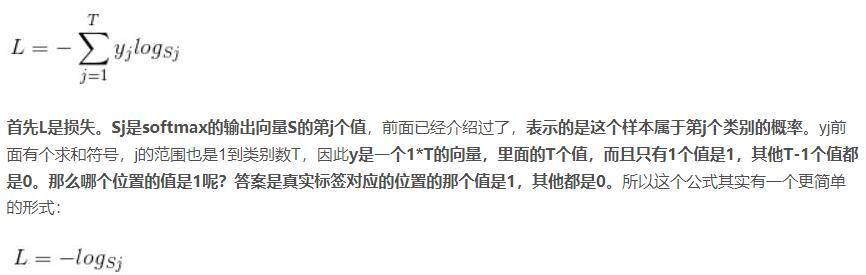

In [28]:
embedding,predict = sess.run([hidden_representation,prediction],feed_dict={x:x_train,y_label:y_train})
print(embedding.shape)
print(vocab_size)
# print(predict)
print(sum(predict[1])  )
# print(y_train)

(34, 5)
7
1.0000000129693944
